# 03. Atmospheric maps from ERA5 atmospheric reanalysis
Data source:

DOI: 10.24381/cds.adbb2d47
<br>
Dataset is daily and hourly Jan 2024

## Import packages

In [37]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift

# ERA5
# from LIB_access_ERA5 import grab_ERA5, fix_cartopy_vectors

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

# math
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Grab atmos. fields by date

In [38]:
filepicker = os.listdir('/Volumes/Seagate2/ERA5/2011')[0]

file_path = f'/Volumes/Seagate2/ERA5/{date.strftime("%Y")}/{filepicker[2:]}'

print(file_path)

/Volumes/Seagate2/ERA5/2011/adaptor.mars.internal-1721195925.7117631-16638-6-484376de-a515-46ba-8533-90ba3e5df1a8.nc


In [39]:
# specify date to import
date = datetime(2011, 1, 1)
date_list = pd.date_range(datetime(2011, 1, 1), datetime(2011, 1, 31)) #make this a date list
#============================

file_path = f'/Volumes/Seagate2/ERA5_transferred/daily/ERA5_{date.strftime("%Y")}_daily.nc'

ds = xr.open_dataset(file_path, drop_variables=["v10", "sst", "t2m", "msl"]) #grab u10
ds.close

<bound method DataWithCoords.close of <xarray.Dataset>
Dimensions:    (time: 365, longitude: 1440, latitude: 141)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 55.5 55.25 55.0
Data variables:
    u10        (time, latitude, longitude) float32 ...>

In [40]:

# specify date to import
date_list = pd.date_range(datetime(2011, 1, 1), datetime(2011, 1, 31)) #make this a date list
#============================

file_path = f'/Volumes/Seagate2/ERA5_transferred/daily/ERA5_{date.strftime("%Y")}_daily.nc'

ds = xr.open_dataset(file_path) #, drop_variables=["v10", "sst", "t2m", "msl"]) #grab u10
ds.close

ds_date = ds.sel(time = date)

ERA5 = {}

ERA5['time'] = ds_date.time.values
ERA5['lon'] = ds_date.longitude.values
ERA5['lat'] = ds_date.latitude.values

ERA5['lon_grid'], ERA5['lat_grid'] = np.meshgrid(ERA5['lon'], ERA5['lat'])

ERA5['u10'] = ds_date.u10.values
ERA5['v10'] = ds_date.v10.values
ERA5['msl'] = ds_date.msl.values
# ERA5['sst'] = ds_date.sst.values

#create empty lists
u10_average = []
v10_average = []
t2m_average = []
date_axs = [] #guess I didn't actually need this haha
sst_average = []
msl_average = []

uv_daily = []

combo_averageuv = []
average_combouv = []

#averaging the values for a given date. takes average vector for each day.
for date in date_list:
    #subsetting data
    date_axs.append(date.to_pydatetime)
    ds_subset = ds.sel(longitude = slice(-150, -138), latitude = slice(72, 69.5), time = slice(date, date + timedelta(hours=23)))
    u10_average.append(ds_subset.mean(dim=("time", "latitude", "longitude")).u10.values)
    # t2m_average.append((ds_subset.mean(dim=("time", "latitude", "longitude")).t2m.values)-273.15) #convert to Celsius
    v10_average.append((ds_subset.mean(dim=("time", "latitude", "longitude")).v10.values))
    msl_average.append((ds_subset.mean(dim=("time", "latitude", "longitude")).msl.values))
    # sst_average.append((ds_subset.mean(dim=("time", "latitude", "longitude")).sst.values))

#triangulating values of uv over a given date
i = 0
while i < len(u10_average):
    uv_daily.append(math.sqrt((u10_average[i])**2 + (v10_average[i])**2))
    i += 1

print(len(u10_average))
print(len(uv_daily))



31
31


In [ ]:
#I think this was trying to get denom of directional constantcy

# print(ds_subset.u10.values.shape)

# for date in date_list:
#     date_axs.append(date.to_pydatetime)
#     i = 0
#     while i < len(ds_subset.u10.values):
#         uv_daily.append(math.sqrt((ds_subset.u10.values[i])**2 + (ds_subset.v10.values[i])**2))
#         i += 1

# print(ds_subset.u10.values.shape)

# print(f'uv_daily is: {uv_daily}')

### Plotting time series of wind speed, etc.

Text(0.5, 1.0, 'Average uv wind from 01-Jan-2011 to 31-Jan-2011 over polynya')

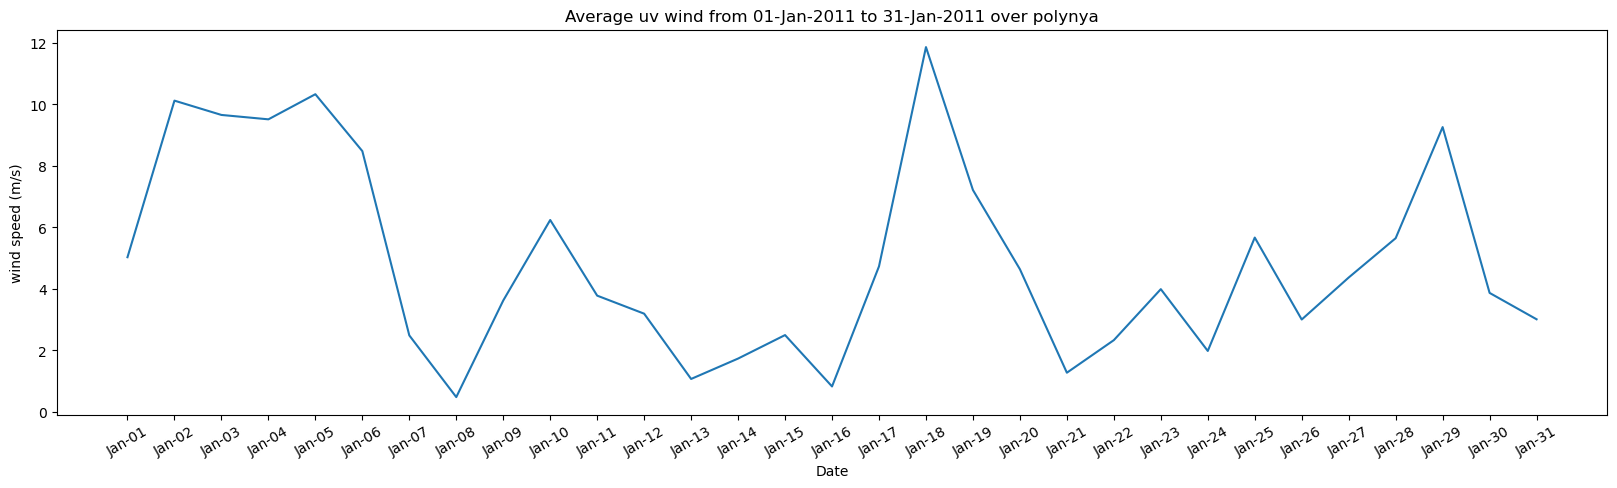

In [41]:
#plotting
x = date_list
y = uv_daily #determine what to plot
fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(x, y)

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(date_list)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#labels
plt.xlabel('Date')
plt.ylabel('wind speed (m/s)')

plt.title(f'Average uv wind from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')

## stick plot of vector directions

Text(0.5, 1.0, 'u-v wind 01-Jan-2011 to 31-Jan-2011 over polynya')

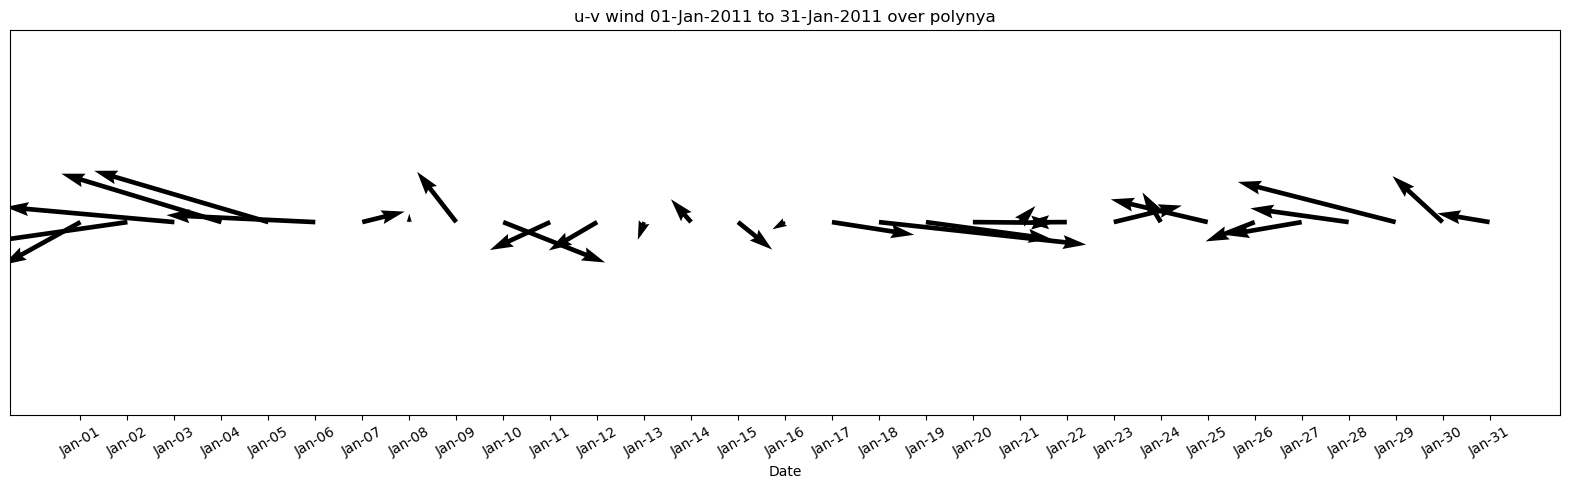

In [42]:
## stick plot
#starts an array

fig, ax = plt.subplots(figsize = (20, 5))
y = np.zeros_like(date_list)

qv = plt.quiver(date_list, y, u10_average, v10_average, width=0.003)
qk = ax.quiverkey(qv, 10, 10, 5, r'$20 \frac{km}{day}$',labelpos='E' )
# x = date_list
# y = uv_daily #determine what to plot
# plt.plot(x, y)

#why is it not showing up!

# save figure, if desired
save_path = f'/Users/reu/Desktop/quiver.png'
fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(date_list)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.yticks([])
#labels
plt.xlabel('Date')
#ax.axvspan(datetime(2024, 1, 10), datetime(2024, 1, 15), facecolor='silver', alpha=0.5)

plt.title(f'u-v wind {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')


In [ ]:
date_list = pd.date_range(datetime(2011, 1, 1), datetime(2011, 1, 31)) #make this a date list

for date in date_list:
    if date.year ==  2004 or 2014 or 2024:
        if date.month == 1:
            print(date)
    if date.year == 2003 or 2013:
        if date.month == 1:
            print(date)

## Make map

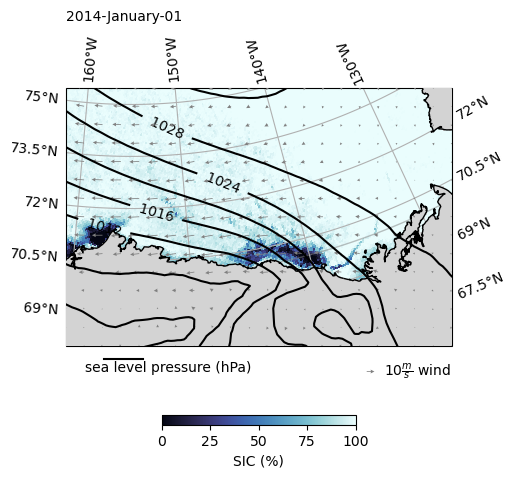

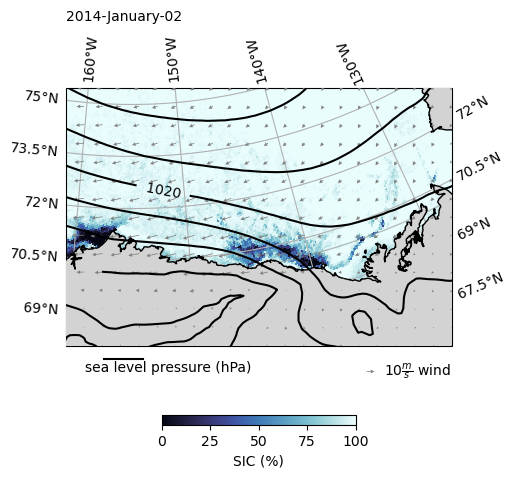

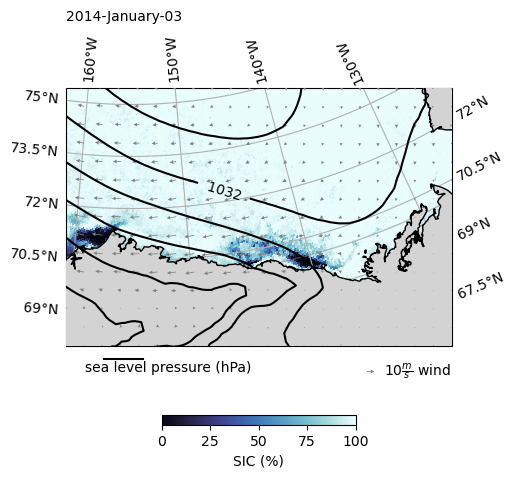

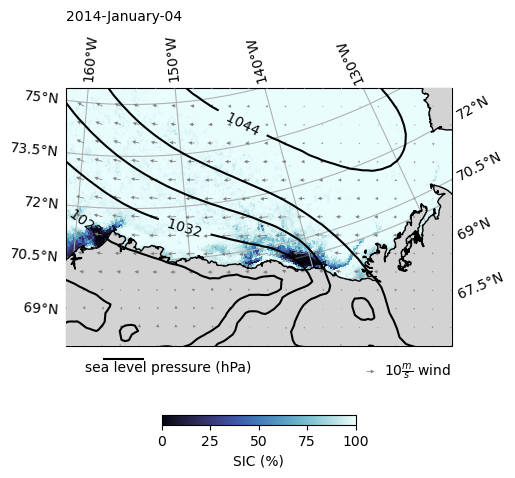

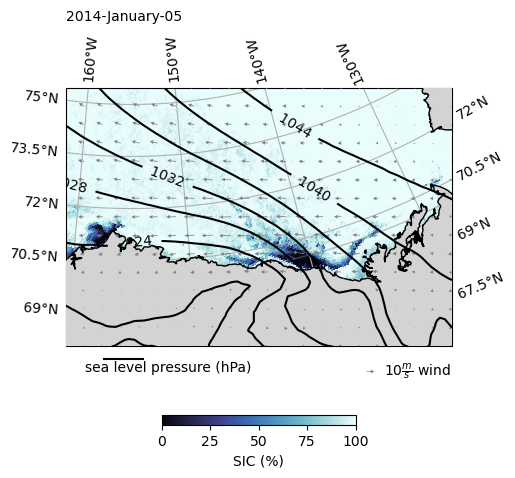

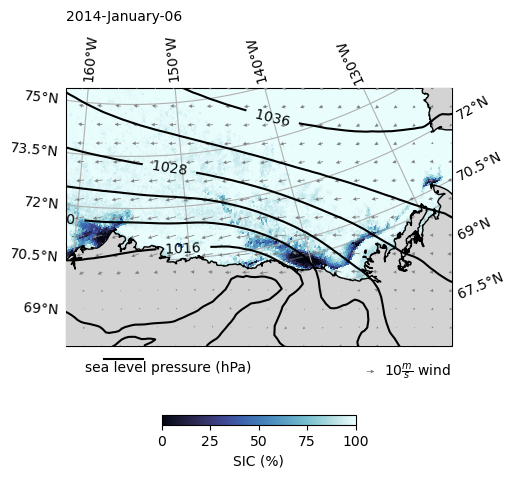

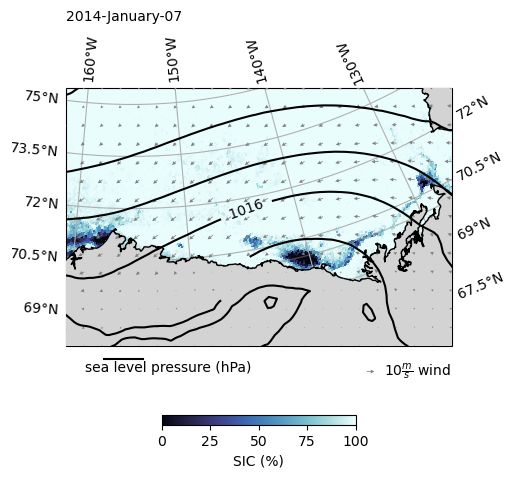

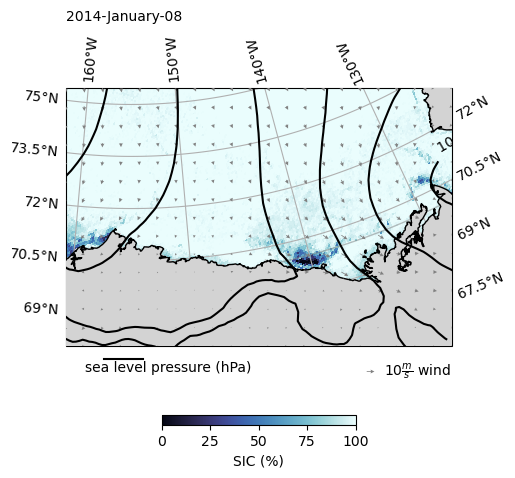

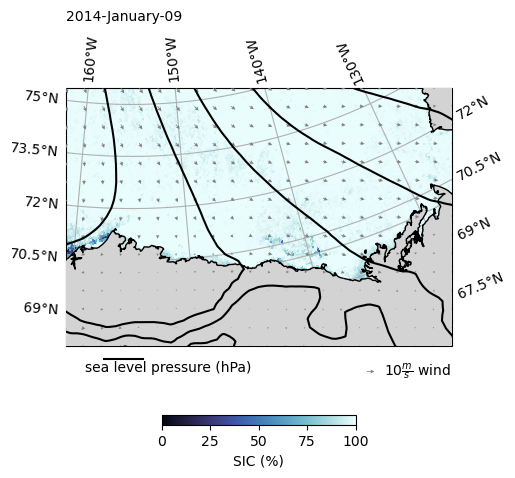

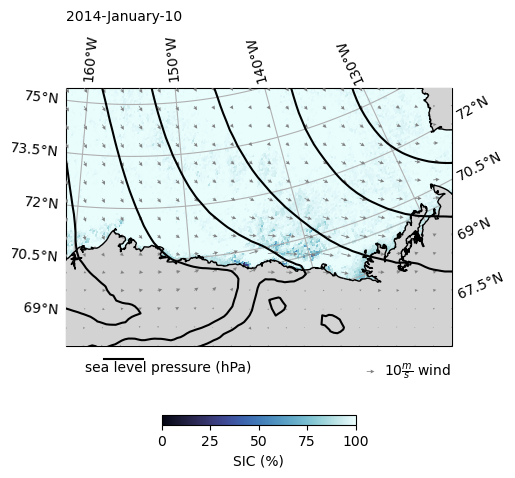

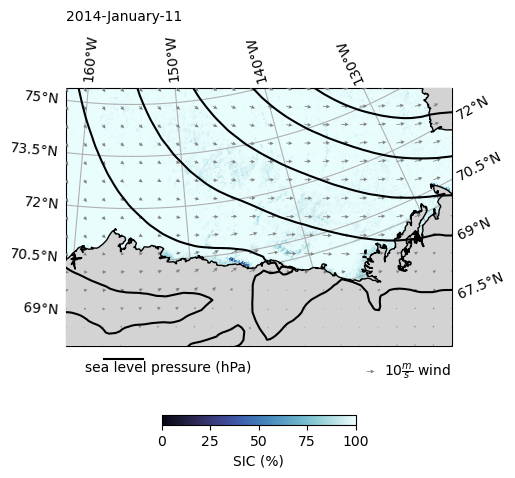

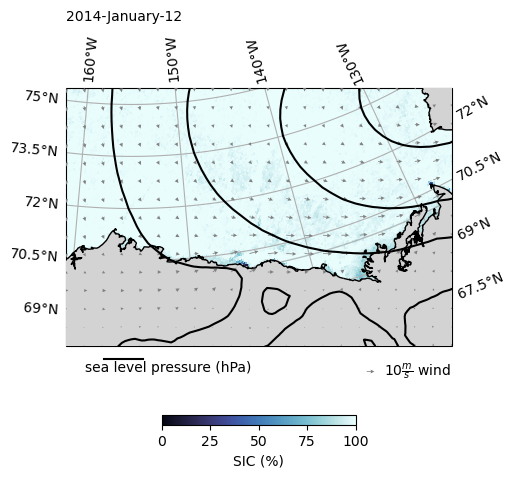

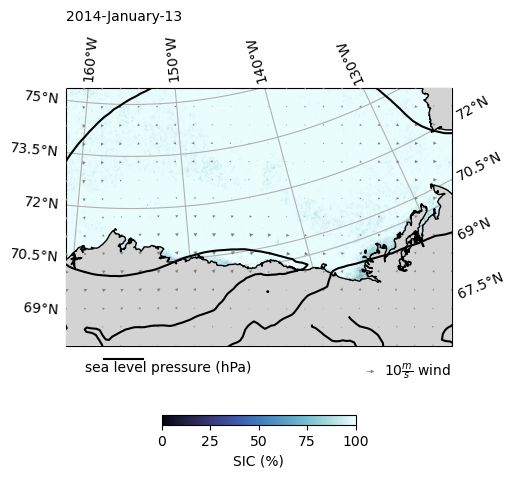

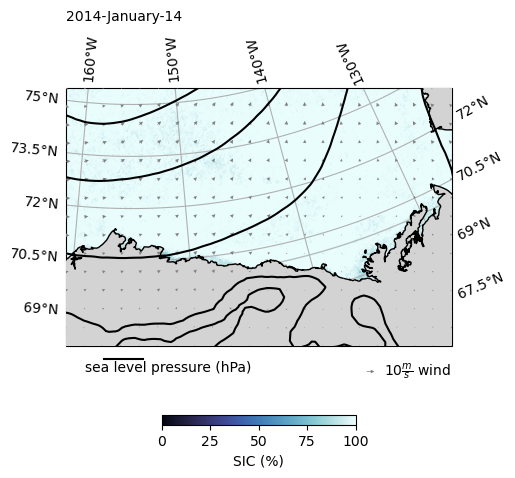

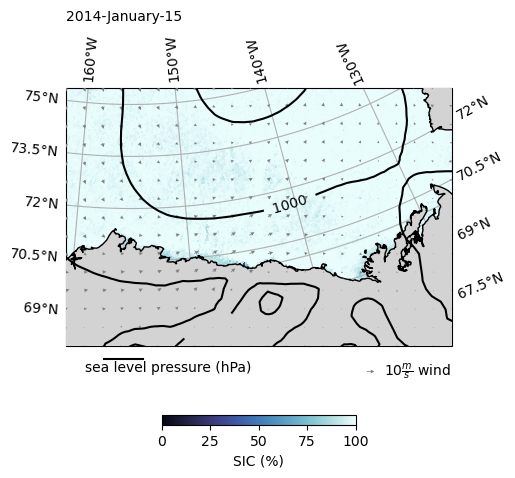

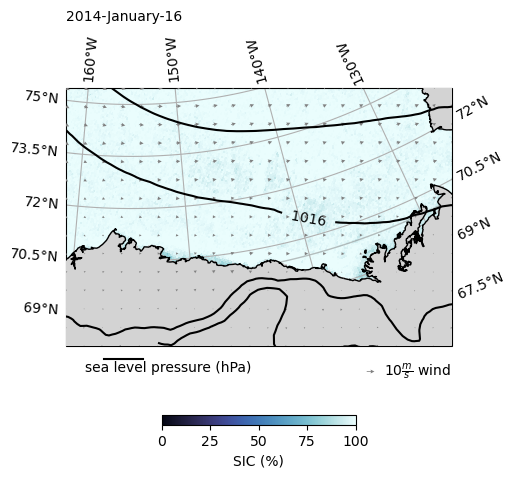

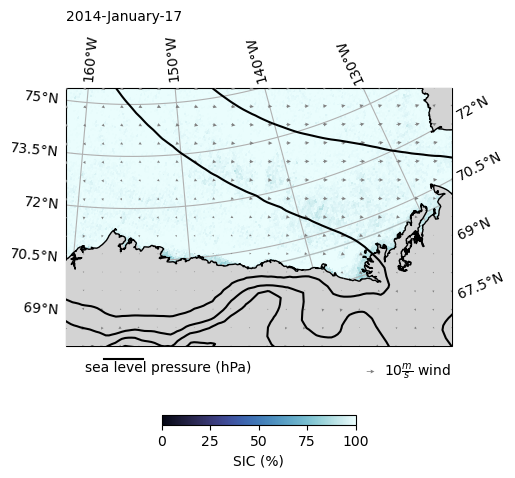

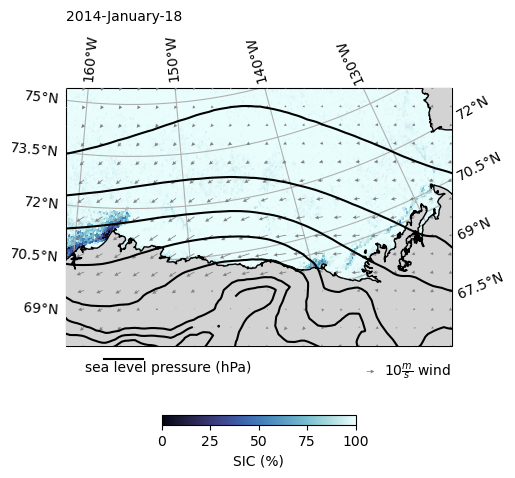

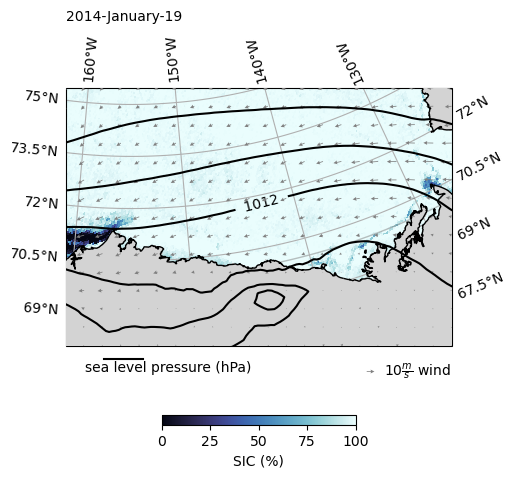

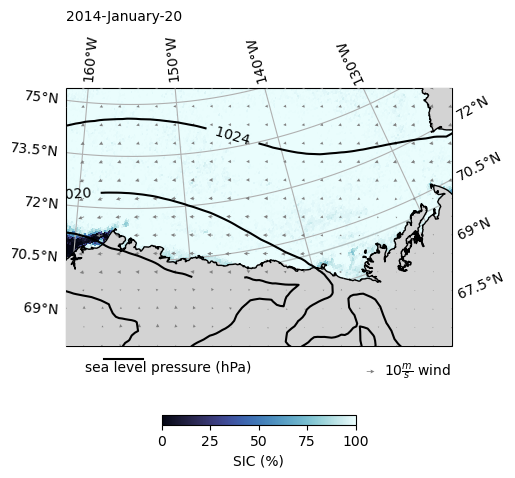

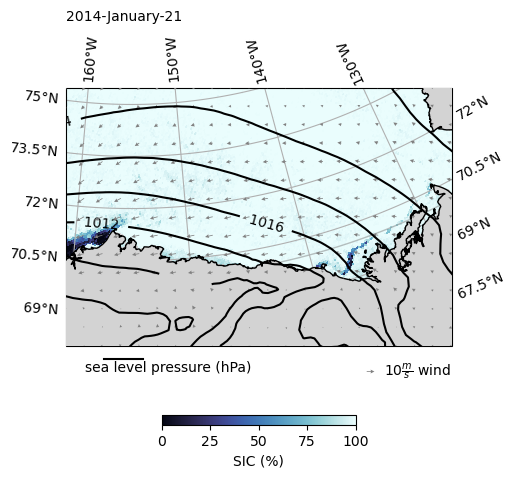

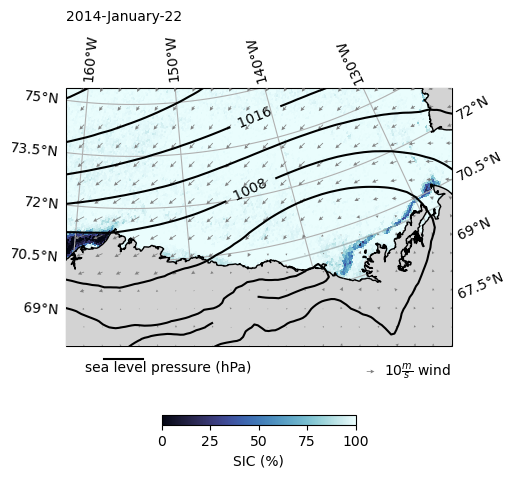

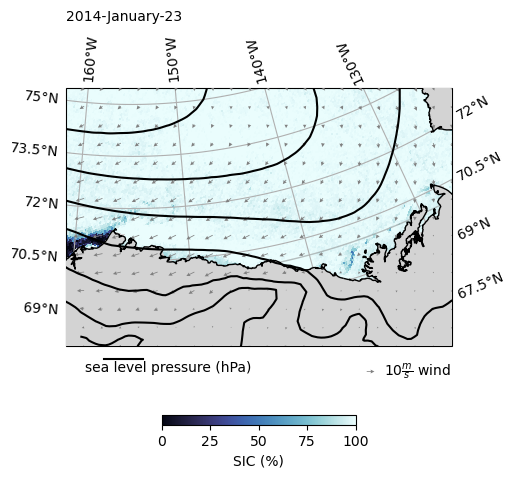

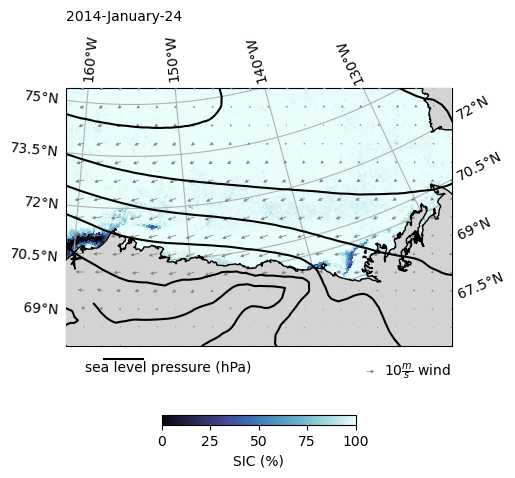

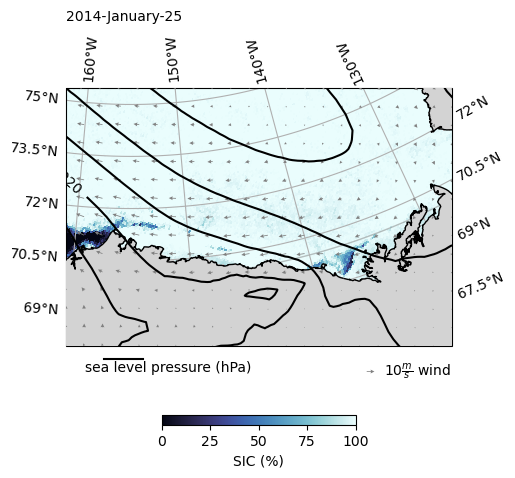

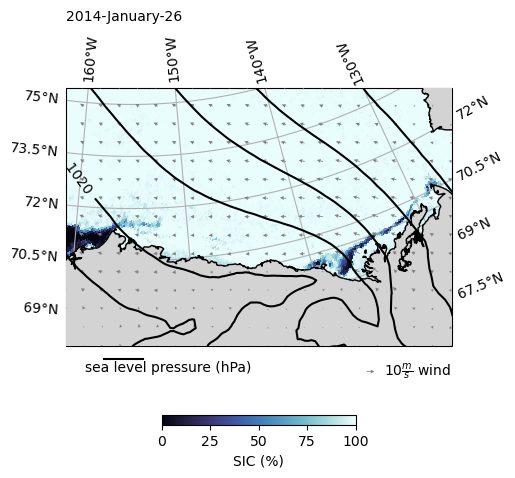

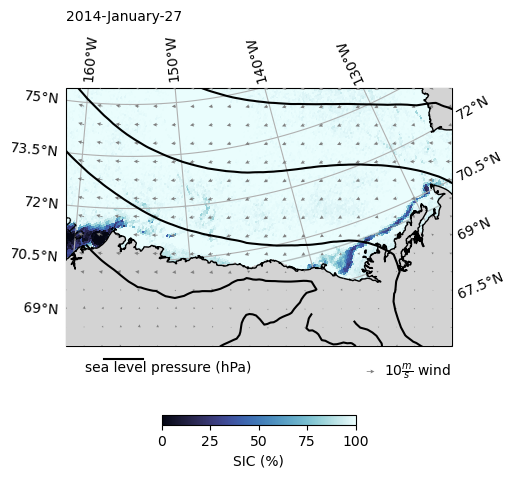

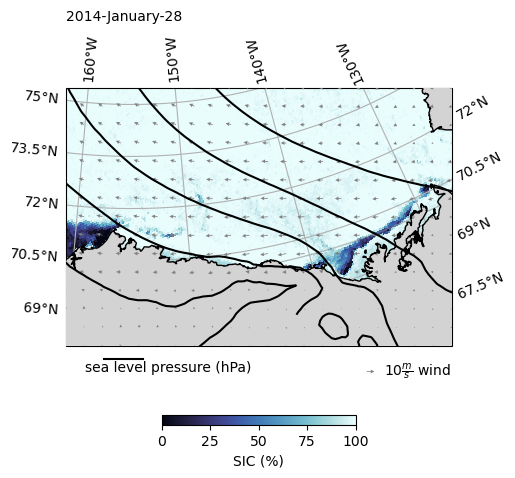

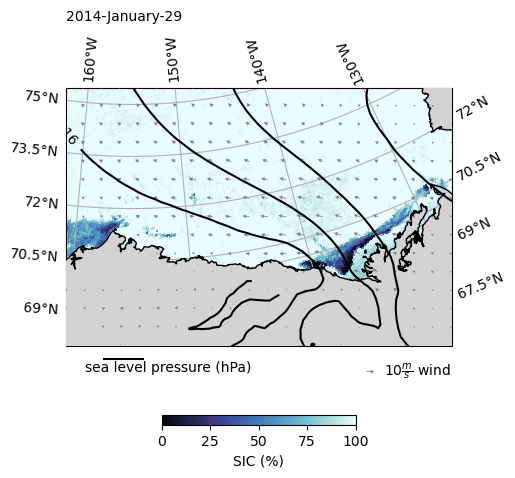

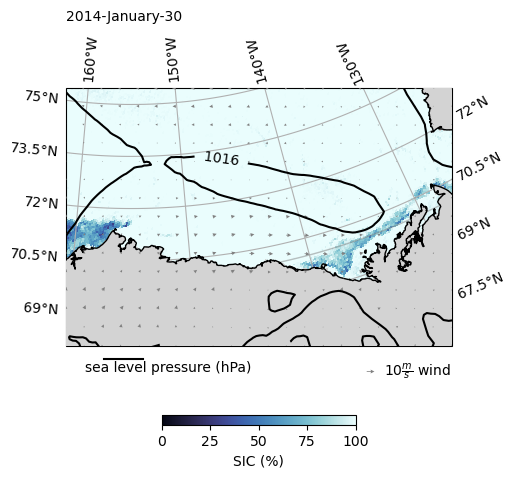

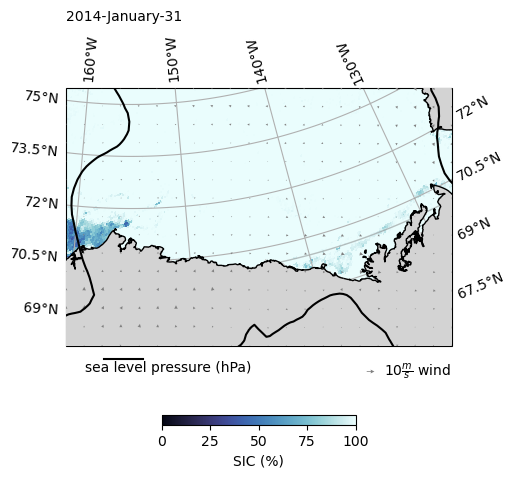

In [44]:

# specify date to plot SIC
#============================
date_list = pd.date_range(datetime(2014, 1, 1), datetime(2014, 1, 31)) #make this a date list
#============================

for date in date_list:
#     if date.year ==  2004 or (date.year == 2014) or (date.year == 2024):
#         if date.month == 1:
        #grabbing ERA5 data
        file_path = f'/Volumes/Seagate2/ERA5_transferred/daily/ERA5_{date.strftime("%Y")}_daily.nc'

        ds = xr.load_dataset(file_path)
        ds.close

        ds_date = ds.sel(time = slice(date, date + timedelta(hours=23))).mean(dim="time")
        #takes daily average of time slice

        ERA5 = {}

        #ERA5['time'] = ds_date.time.values
        ERA5['lon'] = ds_date.longitude.values
        ERA5['lat'] = ds_date.latitude.values

        ERA5['lon_grid'], ERA5['lat_grid'] = np.meshgrid(ERA5['lon'], ERA5['lat'])

        ERA5['u10'] = ds_date.u10.values
        ERA5['v10'] = ds_date.v10.values
        ERA5['msl'] = ds_date.msl.values

        # read daily sic data from computer files into dictionary
        data = grab_ASI_SIC(date=date, 
                        main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                        coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                        hemisphere='n', resolution='6250', version='v5.4', 
                        return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                        include_units=False, annual_folders=False, return_dict = True, quiet=True)

        # create figure
        #--------------
        # create map figure in north polar stereographic projection
        map_projection = ccrs.NorthPolarStereo(central_longitude=205)
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection=map_projection))

        # background color
        ax.patch.set_facecolor('lightgray')

        # set map extent [lon1, lon2, lat1, lat2]
        ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

        # add coastlines
        ax.coastlines(zorder=100)

        # add land
        add_land(ax, scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=5)

        # lat / lon lines
        add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
        gl.bottom_labels = False

        # plot 2d sic data 
        icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                                cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

        #color bar
        plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.18)

        # label date
        ax.text(0, 1.25, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)

        # ERA5 10m wind field
        qv1 = ax.quiver(ERA5['lon_grid'], ERA5['lat_grid'], *fix_cartopy_vectors(ERA5['u10'], ERA5['v10'], ERA5['lat_grid']), 
                        regrid_shape = 15, color = 'gray', width = 0.002, headwidth=5, scale = 500, transform = ccrs.PlateCarree(), zorder=50)
        qk = ax.quiverkey(qv1, 0.8, -0.1, 10, r'$10 \frac{m}{s}$ wind', labelpos='E',transform=ccrs.PlateCarree())

        # ERA5 mean sea level pressure
        line_c = ax.contour(ERA5['lon_grid'], ERA5['lat_grid'], ERA5['msl']/100, 
                levels = np.arange(960,1080,4), colors='k', transform = ccrs.PlateCarree(), zorder=50)

        # Use the line contours to place contour labels.
        ax.clabel(line_c,  # Typically best results when labelling line contours.
                colors=['black'],
                manual=False,  # Automatic placement vs manual placement.
                inline=True,  # Cut the line where the label will be placed.
                fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
                zorder=4
                )

        ax.plot([0.1,0.2], [-0.05, -0.05], clip_on=False, c='k', transform=ax.transAxes)
        ax.text(0.05, -0.1, 'sea level pressure (hPa)', c='k', transform=ax.transAxes)

        plt.show()


        # save figure, if desired
        save_path = f'/Users/reu/Box/Maps/ERA5_maps/{date.strftime("%Y")}/ERA5_daily_map_{date.strftime("%Y-%m-%d")}.png'
        fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

In [ ]:
ds.u10.shape

### Importing data to CSV

In [ ]:
#cutting off January 31st
short_list = []
short_u10_average = []
short_t2m_average = []
short_v10_average = []
i = 0

while i < 30:
    short_list.append(date_list[i])
    short_v10_average.append(v10_average[i])
    short_u10_average.append(u10_average[i])
    short_t2m_average.append(t2m_average[i])
    i = i + 1

print(f'short_list: {len(short_list)}. u10_average: {len(short_u10_average)}. t2m_average: {len(short_t2m_average)}. v10_average: {len(short_v10_average)}')


#exporting data as csv
d = {'time': date_list, 'u10_average(m/s)': u10_average, 't2m_average(m/s)': t2m_average, 'v10_average(m/s)': v10_average, 'uv_wind': uv_daily}
df2 = pd.DataFrame(data=d)
df2.to_csv('/Users/reu/Box/Data/speeds_wind_v2.csv', index=None) #removes Index column



### Plotting all the variables on one

In [ ]:
fig4, ax4 = plt.subplots(figsize=(20,5))

plt.plot(df.time, df2.u10_average, label='u10_average')
plt.plot(df.time, df2.v10_average, label = 'v10_average')
plt.plot(df.time, df.speed_of_mean, label = 'magnitude of mean ice drift vector')
plt.plot(df.time, df.mean_of_speed, label = 'mean magnitude of ice drift vectors')

ax4.legend()

plt.xticks(rotation=30)
plt.title(f'Wind and Drift from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')

df2.time.shape
df2.u10_average.shape

## drift/wind ratio

### Wind speed (combined u-v component)

In [ ]:
#combining the u-v components with MATH

uv_wind = []
i = 0
while i < len(short_u10_average):
    uv_wind.append(math.sqrt(short_u10_average[i]**2 + short_v10_average[i]**2))
    i = i + 1

print(uv_wind)
print(type(uv_wind))
print(len(uv_wind))


In [ ]:
#plotting uv-wind vs. time

fig5, ax5 = plt.subplots(figsize=(20,5))

plt.plot(df.time, uv_wind, label='uv_wind')
# plt.plot(df.time, df2.v10_average, label = 'v10_average')
# plt.plot(df.time, df.speed_of_mean, label = 'magnitude of mean ice drift vector')
# plt.plot(df.time, df.mean_of_speed, label = 'mean magnitude of ice drift vectors')

ax5.legend()

plt.xticks(rotation=30)
plt.title(f'u-v wind from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')

df2.time.shape
df2.u10_average.shape

### calculating wind factor ratios

In [ ]:
#reimports the uv-wind :)
d = {'time': short_list, 'u10_average': short_u10_average, 't2m_average': short_t2m_average, 'v10_average': short_v10_average, 'uv_wind': uv_wind}
df2 = pd.DataFrame(data=d)
df2.to_csv('./Data/speeds_wind.csv', index=None) #removes Index column
df2 = pd.read_csv('./Data/speeds_wind.csv')
df2['time'] = pd.to_datetime(df2.time)


df = pd.read_csv('./Data/speeds_ice.csv')


## calculating wind factor ratio

In [ ]:
drift_ratio_mean_of_speed = []
drift_ratio_speed_of_mean = []
i = 0
while i < len(df.mean_of_speed):
    drift_ratio_mean_of_speed.append(df.mean_of_speed[i] / uv_wind[i])
    drift_ratio_speed_of_mean.append(df.speed_of_mean[i]/ uv_wind[i])
    i +=1 

#plotting drift ratios

fig6, ax6 = plt.subplots(figsize=(20,5))

plt.plot(df.time, drift_ratio_mean_of_speed, label = 'magnitude of mean ice drift vector / uv_wind')

ax6.legend()
plt.xticks(rotation=30)
plt.title(f'Drift ratios from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

## Directional constantcy of wind

In [ ]:
d_constantcy = []
i = 0
while i < len(drift_ratio_mean_of_speed)